# Proyecto 2: Estimación de cantidades futuras de productos sobre el tiempo

## Fase 0 - CONFIGURACIÓN DEL ENTORNO Y CARGA DE DATOS


In [2]:
# -*- coding: utf-8 -*-
# =============================================================================
# FASE 0: CONFIGURACIÓN DEL ENTORNO Y CARGA DE DATOS
# =============================================================================
# Objetivo: Importar librerías, definir rutas de archivos y cargar los
#           datos iniciales de inventario y ventas.
#
# Entregable: DataFrames de pandas con los datos crudos y una primera
#             inspección para verificar la carga correcta.
# =============================================================================

# -----------------------------------------------------------------------------
# Paso 0.1: Importación de Librerías
# -----------------------------------------------------------------------------
# Importamos las librerías que usaremos a lo largo del proyecto.
# - pandas: Para la manipulación y análisis de datos tabulares.
# - numpy: Para operaciones numéricas eficientes.
# - matplotlib y seaborn: Para la visualización de datos.
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Librerías importadas correctamente.")

# -----------------------------------------------------------------------------
# Paso 0.2: Definición de Rutas y Carga de Datos
# -----------------------------------------------------------------------------
# Define las rutas a tus archivos de datos.
# ⚠️ ¡IMPORTANTE! Reemplaza 'ruta/a/tu/archivo_inventario.csv' y
# 'ruta/a/tu/archivo_ventas.csv' con las rutas reales de tus archivos.
# -----------------------------------------------------------------------------
ruta_inventario = 'C:/Users/wild-/OneDrive/Escritorio/Proyectos/ALECO/archivo_inventario.xlsx'
ruta_ventas = 'C:/Users/wild-/OneDrive/Escritorio/Proyectos/ALECO/archivo_ventas.xlsx'


df_inventario_raw = pd.read_excel(ruta_inventario)
df_ventas_raw = pd.read_excel(ruta_ventas)

# Verificamos que los DataFrames no estén vacíos antes de inspeccionarlos
if not df_inventario_raw.empty and not df_ventas_raw.empty:
    print("\n" + "="*50)
    print("INSPECCIÓN INICIAL: BASE DE DATOS DE INVENTARIO")
    print("="*50)

    # Mostramos las primeras 5 filas para ver la estructura
    print("\n--- Primeras 5 filas (head): ---")
    display(df_inventario_raw.head())

    # Obtenemos un resumen técnico: número de filas, columnas, tipos de datos y nulos
    print("\n--- Información general (info): ---")
    df_inventario_raw.info()

    print("\n" + "="*50)
    print("INSPECCIÓN INICIAL: BASE DE DATOS DE VENTAS")
    print("="*50)

    # Mostramos las primeras 5 filas
    print("\n--- Primeras 5 filas (head): ---")
    display(df_ventas_raw.head())

    # Obtenemos el resumen técnico
    print("\n--- Información general (info): ---")
    df_ventas_raw.info()
else:
    print("\n⚠️ No se pueden inspeccionar los datos porque no se cargaron correctamente.")

print("Iniciando procesamiento de datos de ventas...")

# Copiamos para no modificar el dataframe original
df_ventas_proc = df_ventas_raw.copy()

# Filtrar solo por ventas efectivas (ej. 'Cobrada')
# ⚠️ Ajusta el valor 'Cobrada' si en tus datos hay otros estados válidos.
df_ventas_proc = df_ventas_proc[df_ventas_proc['Estado'] == 'Cobrada']

# Convertir la columna 'Creación' a formato de fecha
# El formato '%d/%m/%Y' se ajusta a '1/4/2025'.
df_ventas_proc['Fecha'] = pd.to_datetime(df_ventas_proc['Creación'], format='%d/%m/%Y')

# Crear una columna 'Mes_Ano' para la agregación (ej. '2025-04')
df_ventas_proc['Mes_Ano'] = df_ventas_proc['Fecha'].dt.to_period('M')

# Agrupar por 'Mes_Ano' y sumar los ingresos
df_ingresos_mensuales = df_ventas_proc.groupby('Mes_Ano')['Después de impuestos'].sum().reset_index()
df_ingresos_mensuales.rename(columns={'Después de impuestos': 'Ingresos_Totales'}, inplace=True)

print("✅ Datos de ventas agregados por mes.")
display(df_ingresos_mensuales.head())

print("\nIniciando procesamiento de datos de inventario...")

df_inventario_proc = df_inventario_raw.copy()

# Crear una columna de fecha a partir de la columna 'Mes'
# ⚠️ Esta es una aproximación. Asume que los datos son del mismo año.
# Si tienes datos de varios años, necesitarás una columna de año en tu CSV.
# Aquí mapeamos nombres de meses a números.
meses_map = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}
df_inventario_proc['Mes_Num'] = df_inventario_proc['Mes'].map(meses_map)

# Asumimos un año para crear la fecha. ⚠️ ¡Revisar si es correcto!
# Si tienes una columna de año, úsala aquí.
ANO_DATOS = 2025 # Cambia este valor por el año correcto de tus datos
df_inventario_proc['Fecha'] = pd.to_datetime(dict(year=ANO_DATOS, month=df_inventario_proc['Mes_Num'], day=1))
df_inventario_proc['Mes_Ano'] = df_inventario_proc['Fecha'].dt.to_period('M')


# Pivotar la tabla
# - index: lo que se mantendrá como filas (Mes_Ano)
# - columns: la columna cuyos valores se convertirán en nuevas columnas (Ítem)
# - values: los valores que llenarán las nuevas columnas (Cantidad total)
df_inventario_pivot = df_inventario_proc.pivot_table(
    index='Mes_Ano',
    columns='Ítem',
    values='Cantidad total',
    aggfunc='sum' # Usamos suma por si hay duplicados
).fillna(0) # Rellenamos NaNs con 0, asumiendo que significa sin stock

# Limpiar los nombres de las columnas para que sean válidos
df_inventario_pivot.columns = [f"INV_{col.replace(' ', '_').replace('/', '_')}" for col in df_inventario_pivot.columns]


print("✅ Datos de inventario pivotados.")
display(df_inventario_pivot.head())

print("\nUniendo tablas para crear el DataFrame maestro...")

# Unimos usando 'Mes_Ano' como clave
df_master = pd.merge(
    df_ingresos_mensuales,
    df_inventario_pivot,
    on='Mes_Ano',
    how='inner' # 'inner' join para mantener solo los meses con datos en ambas tablas
)

# Convertir el índice a un timestamp para facilitar el ploteo
df_master['Mes_Ano'] = df_master['Mes_Ano'].dt.to_timestamp()
df_master.set_index('Mes_Ano', inplace=True)


print("✅ ¡DataFrame maestro creado exitosamente!")
print(f"Dimensiones de la tabla final: {df_master.shape[0]} filas y {df_master.shape[1]} columnas.")
display(df_master.head())


✅ Librerías importadas correctamente.

INSPECCIÓN INICIAL: BASE DE DATOS DE INVENTARIO

--- Primeras 5 filas (head): ---


,Mes,Categoría,Ítem,Referencia,Descripción,Cantidad en Principal,Cantidad mínima en Principal,Cantidad máxima en Principal,Cantidad total,Cantidad en remisiones,Unidad,Estado,Costo promedio,Total
0,Mayo,EMPAQUES Y OTROS,GARRAFA,NaN,NaN,0.0,0,0,0.0,0,Unidad,Activo,5900.000000,0.00
1,Mayo,EMPAQUES Y OTROS,GALON,NaN,NaN,-10.0,0,0,276.0,0,Unidad,Activo,1387.804991,-13878.05
2,Mayo,EMPAQUES Y OTROS,1 LIT C/PISTOLA,NaN,NaN,-2.0,10,30,-2.0,0,Unidad,Inactivo,1232.895738,-2465.79
3,Mayo,EMPAQUES Y OTROS,PETT 500 ML C/PISTOLA,NaN,NaN,-24.0,10,30,-24.0,0,Unidad,Inactivo,1217.666667,-29224.00
4,Mayo,EMPAQUES Y OTROS,JABONERO LIT C/CREMERA,NaN,NaN,0.0,6,20,0.0,0,Unidad,Activo,1857.000000,0.00



--- Información general (info): ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Mes                           2940 non-null   object 
 1   Categoría                     2936 non-null   object 
 2   Ítem                          2940 non-null   object 
 3   Referencia                    2050 non-null   object 
 4   Descripción                   63 non-null     object 
 5   Cantidad en Principal         2940 non-null   float64
 6   Cantidad mínima en Principal  2940 non-null   int64  
 7   Cantidad máxima en Principal  2940 non-null   int64  
 8   Cantidad total                2940 non-null   float64
 9   Cantidad en remisiones        2940 non-null   int64  
 10  Unidad                        2940 non-null   object 
 11  Estado                        2940 non-null   object 
 12  Costo promedio           

,Número de comprobante,Estado,Cliente,Creación,Subtotal,Descuento,Antes de impuestos,Impuestos,Después de impuestos
0,PV28325,Cobrada,MARIA HELENA GARCIA,1/4/2025,154800,0.0,154800.0,0,154800.0
1,PV28590,Cobrada,JHON EDINSON V,1/4/2025,139700,5993.9,133706.1,0,133706.1
2,PV28591,Cobrada,MILENA LUCHO,1/4/2025,81500,1008.9,80491.1,0,80491.1
3,PV28592,Cobrada,Consumidor final,1/4/2025,17100,495.9,16604.1,0,16604.1
4,PV28593,Cobrada,Consumidor final,1/4/2025,6800,0.0,6800.0,0,6800.0



--- Información general (info): ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107 entries, 0 to 2106
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Número de comprobante  2107 non-null   object 
 1   Estado                 2107 non-null   object 
 2   Cliente                2107 non-null   object 
 3   Creación               2107 non-null   object 
 4   Subtotal               2107 non-null   int64  
 5   Descuento              2107 non-null   float64
 6   Antes de impuestos     2107 non-null   float64
 7   Impuestos              2107 non-null   int64  
 8   Después de impuestos   2107 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 148.3+ KB
Iniciando procesamiento de datos de ventas...
✅ Datos de ventas agregados por mes.


,Mes_Ano,Ingresos_Totales
0,2025-04,18551362.6
1,2025-05,20730074.9
2,2025-06,18292021.7
3,2025-07,17547081.4



Iniciando procesamiento de datos de inventario...
✅ Datos de inventario pivotados.


,INV_1_L_PETT,INV_1_LIT_BLANCO,INV_1_LIT_C_PISTOLA,INV_1_2_GALON,INV_500_BLANCO_C_TAPA,INV_ACIDO_BORICO__1_4_LIBRA,INV_ACIDO_BORICO_1_2_LIBRA,INV_ACIDO_BORICO_KG,INV_ACIDO_BORICO_LB,INV_ACIDO_OXALICO__1_4_LIBRA,...,INV_VENENO_2_L,INV_VENENO_GALON,INV_VENENO_GARRAFA,INV_VENENO_LIBRA,INV_VENENO_LIBRA_C_PISTOLA,INV_VINALIMPIO_1_L,INV_VINALIMPIO_2_L,INV_VINALIMPIO_GALON,INV_VINALIMPIO_GARRAFA,INV_ZABRA
Mes_Ano,,,,,,,,,,,,,,,,,,,,,
2025-04,9.0,139.0,-2.0,76.0,0.0,32.0,37.0,0.0,9.0,2.0,...,5.0,3.0,0.0,8.0,4.0,12.0,1.0,0.0,2.0,11.0
2025-05,9.0,70.0,-2.0,56.0,0.0,3.0,10.0,0.0,1.0,1.0,...,8.0,-2.0,0.0,3.0,0.0,11.0,10.0,11.0,3.0,11.0
2025-06,9.0,103.0,-2.0,20.0,0.0,42.0,31.0,0.0,14.0,1.0,...,2.0,4.0,0.0,7.0,5.0,37.0,10.0,14.0,2.0,11.0
2025-07,9.0,244.0,-2.0,112.0,0.0,6.0,17.0,0.0,12.0,0.0,...,0.0,-2.0,0.0,0.0,0.0,24.0,5.0,25.0,2.0,11.0



Uniendo tablas para crear el DataFrame maestro...
✅ ¡DataFrame maestro creado exitosamente!
Dimensiones de la tabla final: 4 filas y 746 columnas.


,Ingresos_Totales,INV_1_L_PETT,INV_1_LIT_BLANCO,INV_1_LIT_C_PISTOLA,INV_1_2_GALON,INV_500_BLANCO_C_TAPA,INV_ACIDO_BORICO__1_4_LIBRA,INV_ACIDO_BORICO_1_2_LIBRA,INV_ACIDO_BORICO_KG,INV_ACIDO_BORICO_LB,...,INV_VENENO_2_L,INV_VENENO_GALON,INV_VENENO_GARRAFA,INV_VENENO_LIBRA,INV_VENENO_LIBRA_C_PISTOLA,INV_VINALIMPIO_1_L,INV_VINALIMPIO_2_L,INV_VINALIMPIO_GALON,INV_VINALIMPIO_GARRAFA,INV_ZABRA
Mes_Ano,,,,,,,,,,,,,,,,,,,,,
2025-04-01,18551362.6,9.0,139.0,-2.0,76.0,0.0,32.0,37.0,0.0,9.0,...,5.0,3.0,0.0,8.0,4.0,12.0,1.0,0.0,2.0,11.0
2025-05-01,20730074.9,9.0,70.0,-2.0,56.0,0.0,3.0,10.0,0.0,1.0,...,8.0,-2.0,0.0,3.0,0.0,11.0,10.0,11.0,3.0,11.0
2025-06-01,18292021.7,9.0,103.0,-2.0,20.0,0.0,42.0,31.0,0.0,14.0,...,2.0,4.0,0.0,7.0,5.0,37.0,10.0,14.0,2.0,11.0
2025-07-01,17547081.4,9.0,244.0,-2.0,112.0,0.0,6.0,17.0,0.0,12.0,...,0.0,-2.0,0.0,0.0,0.0,24.0,5.0,25.0,2.0,11.0


## Opción 1: Modelamiento del flujo mes a mes con serie de tiempo ITEM A ITEM

Pronosticar el inventario futuro modelando su flujo (cambio neto) mes a mes, en lugar de su nivel absoluto.

### Paso 1: Calcular los Flujos de Inventario (Cambio Neto Mensual)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df_flujos = df_master.drop('Ingresos_Totales', axis=1).diff()

print("--- Flujos Netos de Inventario (Producción - Ventas) ---")
print("Un número negativo significa que se vendió más de lo que se produjo ese mes.")
display(df_flujos)

--- Flujos Netos de Inventario (Producción - Ventas) ---
Un número negativo significa que se vendió más de lo que se produjo ese mes.


,INV_1_L_PETT,INV_1_LIT_BLANCO,INV_1_LIT_C_PISTOLA,INV_1_2_GALON,INV_500_BLANCO_C_TAPA,INV_ACIDO_BORICO__1_4_LIBRA,INV_ACIDO_BORICO_1_2_LIBRA,INV_ACIDO_BORICO_KG,INV_ACIDO_BORICO_LB,INV_ACIDO_OXALICO__1_4_LIBRA,...,INV_VENENO_2_L,INV_VENENO_GALON,INV_VENENO_GARRAFA,INV_VENENO_LIBRA,INV_VENENO_LIBRA_C_PISTOLA,INV_VINALIMPIO_1_L,INV_VINALIMPIO_2_L,INV_VINALIMPIO_GALON,INV_VINALIMPIO_GARRAFA,INV_ZABRA
Mes_Ano,,,,,,,,,,,,,,,,,,,,,
2025-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-01,0.0,-69.0,0.0,-20.0,0.0,-29.0,-27.0,0.0,-8.0,-1.0,...,3.0,-5.0,0.0,-5.0,-4.0,-1.0,9.0,11.0,1.0,0.0
2025-06-01,0.0,33.0,0.0,-36.0,0.0,39.0,21.0,0.0,13.0,0.0,...,-6.0,6.0,0.0,4.0,5.0,26.0,0.0,3.0,-1.0,0.0
2025-07-01,0.0,141.0,0.0,92.0,0.0,-36.0,-14.0,0.0,-2.0,-1.0,...,-2.0,-6.0,0.0,-7.0,-5.0,-13.0,-5.0,11.0,0.0,0.0


### Organizar items

In [16]:
if 'key_items' not in locals():
    key_items = [col for col in df_master.columns if col.startswith('INV_')][:50]

In [17]:
# -----------------------------------------------------------------------------
# Paso 2: Seleccionar un Ítem y Aislar su Serie de Flujo
# -----------------------------------------------------------------------------
# Usamos el mismo ítem que en el ejemplo anterior para comparar.
item_a_pronosticar = key_items[18]
print(f"\nÍtem seleccionado para la demostración: {item_a_pronosticar}")

# Creamos la serie de tiempo del flujo para este ítem.
ts_flujo_item = df_flujos[item_a_pronosticar]
# También necesitamos la serie original de niveles para el cálculo final.
ts_nivel_item = df_master[item_a_pronosticar]

print(f"\n--- Serie de Tiempo del Flujo para: {item_a_pronosticar} ---")
display(ts_flujo_item)


IndexError: list index out of range


Realizando un pronóstico del flujo para el próximo mes...
✅ Proyección de flujo neto para el próximo mes: 12.00 unidades.

--- Proyección Final de Inventario para INV_1_2_GALON ---
Último inventario conocido: 112.00
Flujo neto proyectado:      +12.00
Inventario final proyectado: 124.00


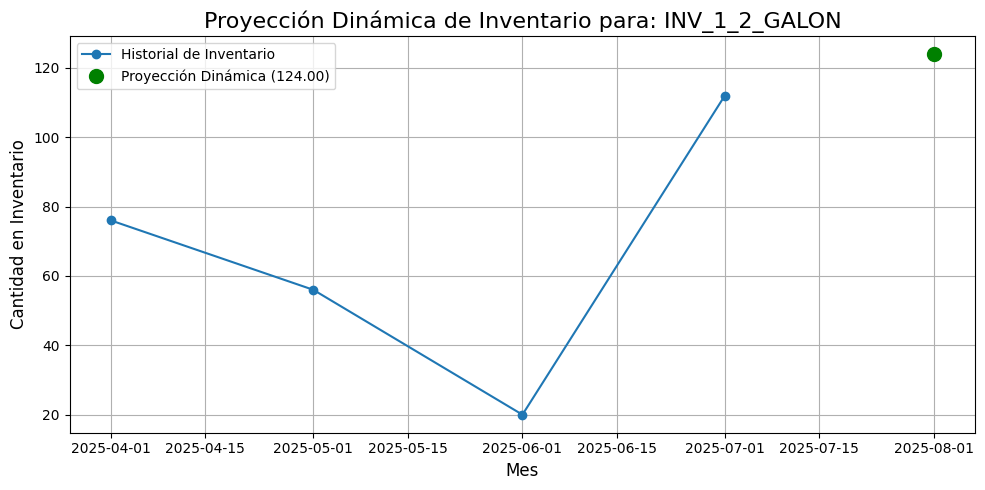

In [15]:


# -----------------------------------------------------------------------------
# Paso 3: Implementar un Modelo de Pronóstico Simple para el Flujo
# -----------------------------------------------------------------------------
# Con pocos datos, un buen modelo base es asumir que el flujo futuro
# será similar al flujo promedio del pasado.
# -----------------------------------------------------------------------------
print("\nRealizando un pronóstico del flujo para el próximo mes...")

# Calculamos el flujo promedio (ignorando el primer valor que es NaN)
flujo_promedio = ts_flujo_item.mean()
proyeccion_flujo_siguiente_mes = flujo_promedio

print(f"✅ Proyección de flujo neto para el próximo mes: {proyeccion_flujo_siguiente_mes:.2f} unidades.")


# -----------------------------------------------------------------------------
# Paso 4: Calcular la Proyección de Inventario Final
# -----------------------------------------------------------------------------
# La proyección final se basa en la ecuación fundamental:
# Inventario(t+1) = Inventario(t) + Flujo_Proyectado(t+1)
# -----------------------------------------------------------------------------
ultimo_inventario_conocido = ts_nivel_item.iloc[-1]
proyeccion_inventario_final = ultimo_inventario_conocido + proyeccion_flujo_siguiente_mes

proxima_fecha = ts_nivel_item.index[-1] + pd.DateOffset(months=1)

print(f"\n--- Proyección Final de Inventario para {item_a_pronosticar} ---")
print(f"Último inventario conocido: {ultimo_inventario_conocido:.2f}")
print(f"Flujo neto proyectado:      {proyeccion_flujo_siguiente_mes:+.2f}")
print(f"Inventario final proyectado: {proyeccion_inventario_final:.2f}")


# -----------------------------------------------------------------------------
# Paso 5: Visualizar el Historial y la Proyección Dinámica
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(ts_nivel_item.index, ts_nivel_item, marker='o', linestyle='-', label='Historial de Inventario')
plt.plot(proxima_fecha, proyeccion_inventario_final, 'go', markersize=10, label=f'Proyección Dinámica ({proyeccion_inventario_final:.2f})')

plt.title(f'Proyección Dinámica de Inventario para: {item_a_pronosticar}', fontsize=16)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Cantidad en Inventario', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Opción 2: Modelamiento complejo con VAR

#### Preparación 

In [ ]:
n_productos_ver = 10

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

print("Preparando los datos para el modelado...")

# La variable 'y' es nuestro objetivo: lo que queremos predecir.
y = df_master['Ingresos_Totales']

# Las variables 'X' son nuestros predictores: todas las columnas de inventario.
X = df_master.drop('Ingresos_Totales', axis=1)

print(f"✅ Datos preparados: {X.shape[1]} variables predictoras (ítems) y {len(y)} observaciones (meses).")

print("\nEntrenando el modelo de Random Forest...")

# Instanciamos el modelo. n_estimators es el número de árboles en el bosque.
# random_state asegura que los resultados sean reproducibles.
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamos el modelo con nuestros datos
model.fit(X, y)

print("✅ Modelo entrenado exitosamente.")

feature_importances = pd.DataFrame({
    'item': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)


Preparando los datos para el modelado...
✅ Datos preparados: 745 variables predictoras (ítems) y 4 observaciones (meses).

Entrenando el modelo de Random Forest...
✅ Modelo entrenado exitosamente.


#### Ejecucción

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

In [ ]:
key_items_subset = feature_importances.head(n_productos_ver)['item'].tolist()

# Creamos el DataFrame para nuestro sistema.
# Usaremos los flujos (diff) ya que son más estacionarios.
df_system = df_master[key_items_subset].diff().dropna()

print(f"--- Sistema de {n_productos_ver} Ítems Clave para el Modelo VAR ---")
display(df_system)


--- Sistema de 10 Ítems Clave para el Modelo VAR ---


,INV_PERFUME_LACOSTE_WHITE_MASC_GR,INV_HUMIDIFICADOR_FLORAL_HERBAL,INV_FRAGANCIA_LAVANDA_FAB,INV_LIMPIA_VIDRIOS_1_L_PISTOLA,INV_PERFUME_ONE_MILLION_LUCKY_MASC_GR,INV_CERA_AUTOBRILLANTE_GALON,INV_PERFUME_CK_ONE_UNISEX_GR,INV_LIMPIA_ESTUFA_GARRAFA,INV_ACIDO_OXALICO_LB,INV_FRAGANCIA_BRISA_MARINA_GR
Mes_Ano,,,,,,,,,,
2025-05-01,-24.0,972.0,-2053.0,0.0,0.0,9.0,0.0,-3.0,-3.0,-226.0
2025-06-01,-24.0,-56.0,2350.0,-4.0,-48.0,-1.0,-12.0,4.0,0.0,210.0
2025-07-01,-12.0,0.0,-600.0,-6.0,0.0,-2.0,0.0,0.0,11.0,303.0


In [ ]:
print("\nEntrenando el modelo VAR...")

try:
    model_var = VAR(df_system)
    
    # CORRECCIÓN: Añadimos trend='n' para manejar el error de columnas constantes.
    # Esto le dice al modelo que no añada un término de intercepto, lo cual es
    # necesario cuando una de las series de datos es constante (un síntoma
    # de tener muy pocos datos).
    results_var = model_var.fit(maxlags=1, trend='n')
    
    print("✅ Modelo VAR entrenado exitosamente.")
    print(results_var.summary())

except Exception as e:
    print(f"❌ Error al entrenar el modelo VAR: {e}")
    print("Esto puede ocurrir si los datos son insuficientes o colineales.")
    results_var = None


Entrenando el modelo VAR...
✅ Modelo VAR entrenado exitosamente.
❌ Error al entrenar el modelo VAR: 3-th leading minor of the array is not positive definite
Esto puede ocurrir si los datos son insuficientes o colineales.


c:\Users\wild-\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
if results_var:
    print("\nRealizando una proyección de flujo para el próximo mes...")
    
    # El modelo necesita los últimos 'p' valores para pronosticar.
    # En nuestro caso, p=1, por lo que necesita el último valor del flujo.
    last_observation = df_system.values[-1:]
    
    # Pronosticamos 1 paso hacia adelante.
    forecast = results_var.forecast(y=last_observation, steps=1)
    
    # Convertimos el resultado en un DataFrame legible.
    df_forecast = pd.DataFrame(forecast, index=['Proyección_Flujo'], columns=df_system.columns)
    
    print("\n--- Proyección de Flujo Neto para el Sistema ---")
    display(df_forecast)

    # -------------------------------------------------------------------------
    # Paso 4: Calcular la Proyección de Inventario Final
    # -------------------------------------------------------------------------
    print("\n--- Proyección Final de Inventario (Basada en VAR) ---")
    
    # Obtenemos los últimos niveles de inventario conocidos.
    last_inventory_levels = df_master[key_items_subset].iloc[-1]
    
    # Proyección = Último Nivel + Flujo Proyectado
    projected_inventory = last_inventory_levels + df_forecast.iloc[0]
    
    display(projected_inventory.to_frame(name='Inventario_Proyectado'))
